Resumo dos dados:
               mes       preco      demanda  elasticidade_real
count  360.000000  360.000000   360.000000         360.000000
mean     6.500000   30.734505  1625.074964          -1.610068
std      3.456857   11.340524  1557.900205           0.907265
min      1.000000   10.315788    98.905998          -2.903712
25%      3.750000   21.314943   259.136796          -2.482408
50%      6.500000   32.767106   833.011391          -1.578657
75%      9.250000   39.720829  2909.672821          -0.736487
max     12.000000   54.440150  5731.422065          -0.285163


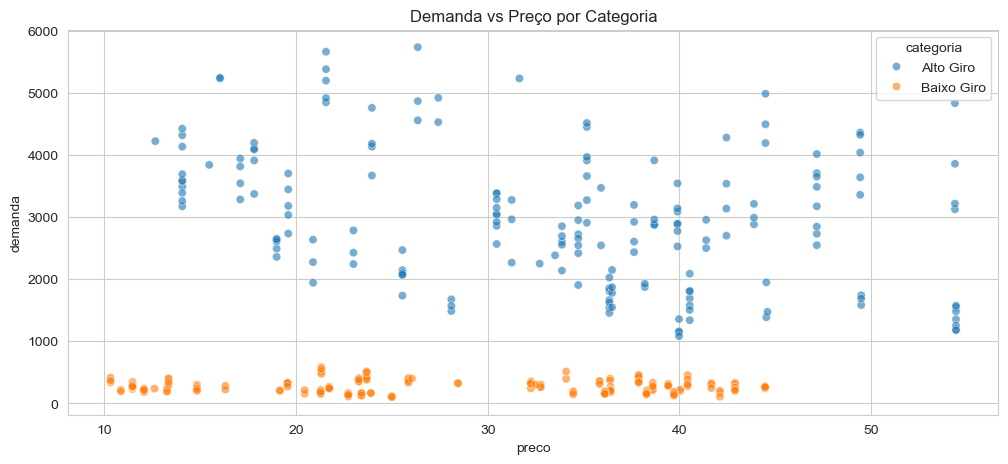


Elasticidade estimada por produto:
      produto  elasticidade_estim        r2       mae   categoria
0  Produto_1           -2.233662  0.736966  0.077340   Alto Giro
1  Produto_2           -2.163694  0.588760  0.092560  Baixo Giro
2  Produto_3           -2.536795  0.613881  0.104948  Baixo Giro
3  Produto_4            0.105655  0.006229  0.073309  Baixo Giro
4  Produto_5            0.306824  0.060767  0.079008   Alto Giro

Produtos candidatos a aumento de preço e impacto estimado:
        produto  categoria  preco_antigo  preco_novo  demanda_antiga  \
23  Produto_24  Alto Giro     40.236912   44.260603     2993.863434   
4    Produto_5  Alto Giro     37.010218   40.711239     2672.225058   
21  Produto_22  Alto Giro     45.602538   50.162792     3315.530010   
22  Produto_23  Alto Giro     23.555485   25.911034     4822.556992   
5    Produto_6  Alto Giro     14.058862   15.464748     3756.914793   

    demanda_nova  receita_antiga   receita_nova  delta_receita  \
23   3022.237571   

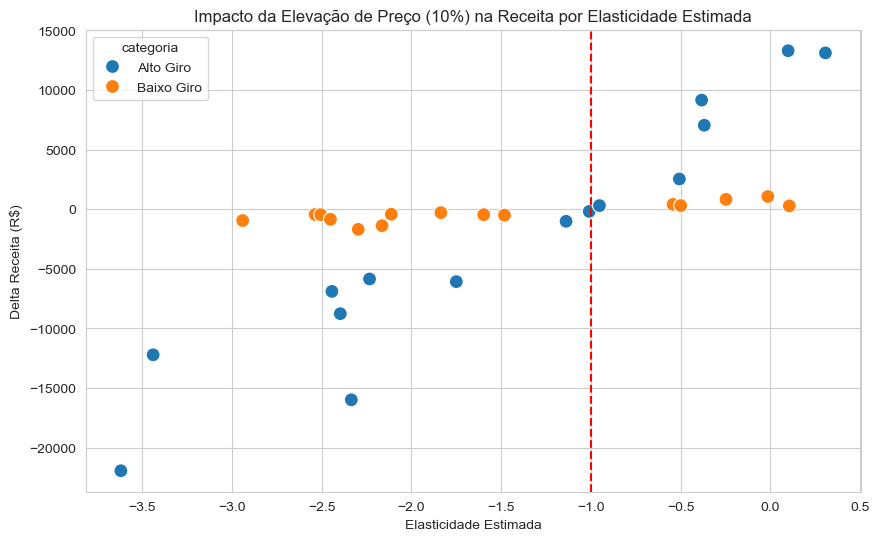

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# --- 1. Simulação dos dados ---

np.random.seed(42)

n_products = 30
n_months = 12

# Gerar IDs e categorias (alto/baixo giro)
products = [f'Produto_{i+1}' for i in range(n_products)]
categories = np.random.choice(['Alto Giro', 'Baixo Giro'], size=n_products, p=[0.4, 0.6])

# Elasticidades reais (entre -3 e -0.2, mais negativo = mais sensível)
elasticities = np.random.uniform(-3, -0.2, n_products)

data = []

for i, prod in enumerate(products):
    category = categories[i]
    elasticity = elasticities[i]

    base_price = np.random.uniform(10, 50)
    base_demand = np.random.uniform(1000, 5000) if category == 'Alto Giro' else np.random.uniform(100, 500)

    for month in range(1, n_months + 1):
        # Simula variação sazonal e promoções (ruído)
        seasonality_factor = 1 + 0.1 * np.sin(2 * np.pi * month / 12)
        promotion = np.random.choice([0.9, 1, 1.1], p=[0.2, 0.6, 0.2])

        price = base_price * promotion
        demand = base_demand * (price / base_price) ** elasticity * seasonality_factor

        # Ruído normal no volume vendido
        demand_observed = max(0, np.random.normal(demand, scale=demand*0.1))

        data.append([prod, category, month, price, demand_observed, elasticity])

df = pd.DataFrame(data, columns=['produto', 'categoria', 'mes', 'preco', 'demanda', 'elasticidade_real'])

# --- 2. EDA simples ---

print("Resumo dos dados:\n", df.describe())

plt.figure(figsize=(12,5))
sns.scatterplot(data=df, x='preco', y='demanda', hue='categoria', alpha=0.6)
plt.title('Demanda vs Preço por Categoria')
plt.show()

# Média por produto
df_mean = df.groupby(['produto', 'categoria']).agg({
    'preco': 'mean',
    'demanda': 'mean',
    'elasticidade_real': 'mean'
}).reset_index()

# --- 3. Modelagem elasticidade log-log ---

# Criar variáveis logarítmicas
df['log_preco'] = np.log(df['preco'])
df['log_demanda'] = np.log(df['demanda'] + 1e-3)  # evitar log(0)

# Modelo para cada produto (regressão linear simples log-log)
results = []
for prod in df['produto'].unique():
    subset = df[df['produto'] == prod]
    X = subset[['log_preco']].values
    y = subset['log_demanda'].values

    if len(subset) < 3:  # pouco dado, ignora
        continue

    model = LinearRegression().fit(X, y)
    pred = model.predict(X)

    r2 = r2_score(y, pred)
    mae = mean_absolute_error(y, pred)
    beta = model.coef_[0]  # elasticidade estimada

    results.append({
        'produto': prod,
        'elasticidade_estim': beta,
        'r2': r2,
        'mae': mae
    })

df_results = pd.DataFrame(results).merge(df_mean[['produto', 'categoria']], on='produto')

print("\nElasticidade estimada por produto:\n", df_results.head())

# --- 4. Simulação impacto financeiro ---

# Vamos supor que queremos aumentar o preço em 10% para produtos com elasticidade estimada > -1.0 (menos sensíveis)
increase_pct = 0.10

impact_data = []
for _, row in df_results.iterrows():
    prod = row['produto']
    elasticidade = row['elasticidade_estim']
    categoria = row['categoria']

    # Média preço e demanda do produto
    mean_preco = df_mean.loc[df_mean['produto'] == prod, 'preco'].values[0]
    mean_demanda = df_mean.loc[df_mean['produto'] == prod, 'demanda'].values[0]

    # Novo preço e demanda estimada pela elasticidade
    new_preco = mean_preco * (1 + increase_pct)
    new_demanda = mean_demanda * (new_preco / mean_preco) ** elasticidade

    # Receita antiga e nova
    receita_antiga = mean_preco * mean_demanda
    receita_nova = new_preco * new_demanda
    receita_diff = receita_nova - receita_antiga

    impact_data.append({
        'produto': prod,
        'categoria': categoria,
        'preco_antigo': mean_preco,
        'preco_novo': new_preco,
        'demanda_antiga': mean_demanda,
        'demanda_nova': new_demanda,
        'receita_antiga': receita_antiga,
        'receita_nova': receita_nova,
        'delta_receita': receita_diff,
        'elasticidade_estim': elasticidade
    })

df_impact = pd.DataFrame(impact_data)

# Mostrar os produtos onde faz sentido aumentar preço (elasticidade > -1)
df_impact_positivos = df_impact[df_impact['elasticidade_estim'] > -1].sort_values('delta_receita', ascending=False)

print("\nProdutos candidatos a aumento de preço e impacto estimado:\n", df_impact_positivos.head())

# --- Visualizar impacto receita vs elasticidade ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_impact, x='elasticidade_estim', y='delta_receita', hue='categoria', s=100)
plt.axvline(-1, color='red', linestyle='--')
plt.title('Impacto da Elevação de Preço (10%) na Receita por Elasticidade Estimada')
plt.xlabel('Elasticidade Estimada')
plt.ylabel('Delta Receita (R$)')
plt.show()
